# Cifar10 Outlier Detection with Kfserving
![demo](./demo.png)

Prequisites:

 * Running cluster with kfserving installed and authenticated for use with `kubectl`
    * Istio with Istio Gateway exposed on a LoadBalancer
 * Knative eventing installed
 * Pip install the alibi_detect library.

## Setup Resources

Enabled eventing on default namespace. This will activate a default Knative Broker.

In [1]:
!kubectl label namespace default knative-eventing-injection=enabled

error: 'knative-eventing-injection' already has a value (enabled), and --overwrite is false


Create a Knative service to log events it receives. This will be the example final sink for outlier events.

In [1]:
!pygmentize message-logger.yaml

apiVersion: eventing.knative.dev/v1alpha1
kind: Trigger
metadata:
  name: seldon-request-logger-trigger
  namespace: default
spec:
  subscriber:
    ref:
      apiVersion: serving.knative.dev/v1
      kind: Service
      name: seldon-request-logger
---
apiVersion: serving.knative.dev/v1
kind: Service
metadata:
  name: seldon-request-logger
  namespace: default
  metadata:
    labels:
    fluentd: "true"
spec:
  template:
    metadata:
      annotations:
        autoscaling.knative.dev/minScale: "1"
    spec:
      containers:
        - image: docker.io/ryandawsonuk/seldon-request-logger-cifar:latest
          imagePullPolicy: Always
          env:
           - name: ELASTICSEARCH_HOST
             value: "elasticsearch-master.logs.svc.cluster.local"
           - name: ELASTICSEARCH_PORT
             value: "9200"


In [2]:
!kubectl apply -f message-logger.yaml

trigger.eventing.knative.dev/seldon-request-logger-trigger unchanged
service.serving.knative.dev/seldon-request-logger configured


Install elasticsearch

In [4]:
!kubectl create namespace logs || echo "namespace logs exists"
!helm upgrade --install elasticsearch elasticsearch --version 7.6.0 --namespace=logs --set service.type=ClusterIP --set antiAffinity="soft" --repo https://helm.elastic.co  --set image=docker.elastic.co/elasticsearch/elasticsearch-oss
!helm upgrade --install kibana kibana --version 7.6.0 --namespace=logs --set service.type=ClusterIP --repo https://helm.elastic.co --set image=docker.elastic.co/kibana/kibana-oss

Error from server (AlreadyExists): namespaces "logs" already exists
namespace logs exists
Release "elasticsearch" has been upgraded. Happy Helming!
NAME: elasticsearch
LAST DEPLOYED: Thu Feb 27 10:56:37 2020
NAMESPACE: logs
STATUS: deployed
REVISION: 2
NOTES:
1. Watch all cluster members come up.
  $ kubectl get pods --namespace=logs -l app=elasticsearch-master -w
2. Test cluster health using Helm test.
  $ helm test elasticsearch
Release "kibana" has been upgraded. Happy Helming!
NAME: kibana
LAST DEPLOYED: Thu Feb 27 10:56:44 2020
NAMESPACE: logs
STATUS: deployed
REVISION: 2
TEST SUITE: None


Create the Kfserving image classification model for Cifar10. We add in a `logger` for requests - the default destination is the namespace Knative Broker.

In [3]:
!pygmentize cifar10.yaml

apiVersion: "serving.kubeflow.org/v1alpha2"
kind: "InferenceService"
metadata:
  name: "pytorch-cifar10"
spec:
  default:
    predictor:
      minReplicas: 1
      pytorch:
        storageUri: "gs://kfserving-samples/models/pytorch/cifar10/"
        modelClassName: "Net"
      logger:
        mode: all


In [4]:
!kubectl apply -f cifar10.yaml

inferenceservice.serving.kubeflow.org/pytorch-cifar10 unchanged


Create the pretrained VAE Cifar10 Outlier Detector. We forward replies to the message-dumper we started.

In [5]:
!pygmentize cifar10od.yaml

apiVersion: serving.knative.dev/v1
kind: Service
metadata:
  name: vae-outlier
spec:
  template:
    metadata:
      annotations:
        autoscaling.knative.dev/minScale: "1"
    spec:
      containers:
      - image: ryandawsonuk/cifar10od:0.0.4
        imagePullPolicy: Always
        args:
        - --model_name
        - vaeod
        - --storage_uri
        - ./vae_outlier_detector/
        - --reply_url
        - http://seldon-request-logger.default
        - --event_type
        - org.kubeflow.serving.inference.outlier


In [6]:
!kubectl apply -f cifar10od.yaml

service.serving.knative.dev/vae-outlier created


Create a Knative trigger to forward logging events to our Outlier Detector.

In [7]:
!pygmentize trigger.yaml

apiVersion: eventing.knative.dev/v1alpha1
kind: Trigger
metadata:
  name: vaeoutlier-trigger
  namespace: default
spec:
  filter:
    sourceAndType:
      type: org.kubeflow.serving.inference.request
  subscriber:
    ref:
      apiVersion: serving.knative.dev/v1alpha1
      kind: Service
      name: vae-outlier
      


In [8]:
!kubectl apply -f trigger.yaml

trigger.eventing.knative.dev/vaeoutlier-trigger unchanged


Get the IP address of the Istio Ingress Gateway. This assumes you have installed istio with a LoadBalancer.

In [9]:
CLUSTER_IPS=!(kubectl -n istio-system get service istio-ingressgateway -o jsonpath='{.status.loadBalancer.ingress[0].ip}')
CLUSTER_IP=CLUSTER_IPS[0]
print(CLUSTER_IP)

34.70.215.56


In [10]:
SERVICE_HOSTNAMES=!(kubectl get inferenceservice pytorch-cifar10 -o jsonpath='{.status.url}' | cut -d "/" -f 3)
SERVICE_HOSTNAME_CIFAR10=SERVICE_HOSTNAMES[0]
print(SERVICE_HOSTNAME_CIFAR10)

pytorch-cifar10.default.example.com


In [11]:
SERVICE_HOSTNAMES=!(kubectl get ksvc vae-outlier -o jsonpath='{.status.url}' | cut -d "/" -f 3)
SERVICE_HOSTNAME_VAEOD=SERVICE_HOSTNAMES[0]
print(SERVICE_HOSTNAME_VAEOD)

vae-outlier.default.example.com


In [12]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.keras.backend.clear_session()

from alibi_detect.od.vae import OutlierVAE
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.visualize import plot_feature_outlier_image
import requests

train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def pytorch_transform(X):
    img = (X - 0.5) * 2.0
    return np.transpose(img, (0,3, 1, 2))

def show(X):
    plt.imshow(X.reshape(32, 32, 3))
    plt.axis('off')
    plt.show()

def predict(X):
    X = pytorch_transform(X)
    formData = {
    'instances': X.tolist()
    }
    headers = {}
    headers["Host"] = SERVICE_HOSTNAME_CIFAR10
    res = requests.post('http://'+CLUSTER_IP+'/v1/models/pytorch-cifar10:predict', json=formData, headers=headers)
    if res.status_code == 200:
        return classes[np.array(res.json()["predictions"])[0].argmax()]
    else:
        print("Failed with ",res.status_code)
        return []
    
def outlier(X):
    X = pytorch_transform(X)
    formData = {
    'instances': X.tolist()
    }
    headers = {"alibi-detect-return-feature-score":"true","alibi-detect-return-instance-score":"true"}
    headers["Host"] = SERVICE_HOSTNAME_VAEOD
    res = requests.post('http://'+CLUSTER_IP+'/', json=formData, headers=headers)
    if res.status_code == 200:
        od = res.json()
        od["data"]["feature_score"] = np.array(od["data"]["feature_score"])
        od["data"]["instance_score"] = np.array(od["data"]["instance_score"])
        return od
    else:
        print("Failed with ",res.status_code)
        return []

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


## Normal Prediction

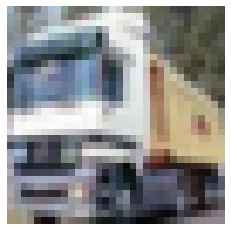

'truck'

In [14]:
idx = 1
X = X_train[idx:idx+1]
show(X)
predict(X)

Record of this predictions and outlier will now be in elasticsearch. Access this by running `kubectl port-forward svc/kibana-kibana -n logs 5601:5601` and going to `localhost:5601` as per the seldon core request logging example. Go to the 'Discover' menu and create a timestamp-based kibana index using a wildcard (*).

## Outlier Prediction

In [18]:
np.random.seed(0) 
X_mask, mask = apply_mask(X.reshape(1, 32, 32, 3),
                                  mask_size=(10,10),
                                  n_masks=1,
                                  channels=[0,1,2],
                                  mask_type='normal',
                                  noise_distr=(0,1),
                                  clip_rng=(0,1))

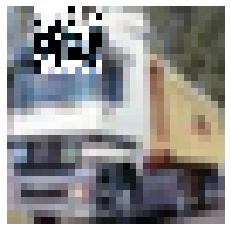

'truck'

In [22]:
show(X_mask)
predict(X_mask)

A new event entry will now be in kibana.

This shows an outlier was detected: `is_outlier: [1]`

We will now call our outlier detector directly and ask for the feature scores to gain more information about why it predicted this instance was an outlier.

In [20]:
od_preds = outlier(X_mask)

We now plot those feature scores returned along with our original image.

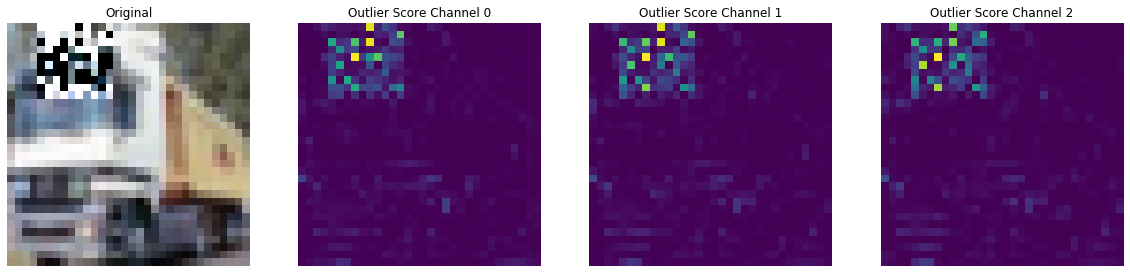

In [21]:
plot_feature_outlier_image(od_preds, 
                           X_mask, 
                           X_recon=None)